In [1]:
# imports

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RepeatedKFold, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pickle

In [2]:
# config

config = {
    'seed': 12345
}

In [19]:
# load data

df = pd.read_csv('data/reviews_simple_preprocessed.csv')

df['rating_item'] = df['rating_item'].fillna(0)
df['rating_delivery'] = df['rating_delivery'].fillna(0)
df['rating_seller'] = df['rating_seller'].fillna(0)
df['rating_marketplace'] = df['rating_marketplace'].fillna(0)

df['rating_item'] = df['rating_item'].astype(int)
df['rating_delivery'] = df['rating_delivery'].astype(int)
df['rating_seller'] = df['rating_seller'].astype(int)
df['rating_marketplace'] = df['rating_marketplace'].astype(int)

df['rating_item'] = df['rating_item'].astype(str)
df['rating_delivery'] = df['rating_delivery'].astype(str)
df['rating_seller'] = df['rating_seller'].astype(str)
df['rating_marketplace'] = df['rating_marketplace'].astype(str)

df.loc[df['rating_item'] == '0', 'rating_item'] = 'na'
df.loc[df['rating_delivery'] == '0', 'rating_delivery'] = 'na'
df.loc[df['rating_seller'] == '0', 'rating_seller'] = 'na'
df.loc[df['rating_marketplace'] == '0', 'rating_marketplace'] = 'na'

df.loc[df['rating_item'].isin(['1', '2']), 'rating_item'] = 'negative'
df.loc[df['rating_item'] == '3', 'rating_item'] = 'neutral'
df.loc[df['rating_item'].isin(['4', '5']), 'rating_item'] = 'positive'
df.loc[df['rating_delivery'].isin(['1', '2']), 'rating_delivery'] = 'negative'
df.loc[df['rating_delivery'] == '3', 'rating_delivery'] = 'neutral'
df.loc[df['rating_delivery'].isin(['4', '5']), 'rating_delivery'] = 'positive'
df.loc[df['rating_seller'].isin(['1', '2']), 'rating_seller'] = 'negative'
df.loc[df['rating_seller'] == '3', 'rating_seller'] = 'neutral'
df.loc[df['rating_seller'].isin(['4', '5']), 'rating_seller'] = 'positive'
df.loc[df['rating_marketplace'].isin(['1', '2']), 'rating_marketplace'] = 'negative'
df.loc[df['rating_marketplace'] == '3', 'rating_marketplace'] = 'neutral'
df.loc[df['rating_marketplace'].isin(['4', '5']), 'rating_marketplace'] = 'positive'

df.head()

,title,body,rating_item,rating_delivery,rating_seller,rating_marketplace,rating_total
0,i recently purchased a mobile phone and i must...,a solid purchase by experience with this mobil...,neutral,na,na,na,3
1,i recently received a new mobile phone in the ...,pleasant purchase experience by thought on a n...,na,negative,positive,negative,4
2,i recently purchased a new mobile phone and al...,pleasantly surprised by the feature of this mo...,neutral,na,na,na,4
3,i recently made a purchase for a new mobile ph...,average experience with my new mobile shone de...,positive,na,negative,negative,3
4,i recently purchased a mobile phone from an on...,boxing the shone a neutral review regarding th...,na,na,na,neutral,3


In [20]:
# transform data

df['title'] = df['title'].fillna('')
df['review'] = ((df['title'] + ' ') if len(df['title']) > 0 else '') + df['body']

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['review'])
y_item = df[['rating_item']]
y_delivery = df[['rating_delivery']]
y_seller = df[['rating_seller']]
y_marketplace = df[['rating_marketplace']]

In [21]:
# split data

X_item_train, X_item_test, y_item_train, y_item_test = train_test_split(X, y_item, test_size=0.2, random_state=config['seed'])
X_delivery_train, X_delivery_test, y_delivery_train, y_delivery_test = train_test_split(X, y_delivery, test_size=0.2, random_state=config['seed'])
X_seller_train, X_seller_test, y_seller_train, y_seller_test = train_test_split(X, y_seller, test_size=0.2, random_state=config['seed'])
X_marketplace_train, X_marketplace_test, y_marketplace_train, y_marketplace_test = train_test_split(X, y_marketplace, test_size=0.2, random_state=config['seed'])

In [22]:
# train model

tuning_grid = dict(
    kernel = ['linear', 'rbf', 'sigmoid', 'poly'],
    C = range(1, 11, 1),
    degree = range(11),
    gamma = ['scale', 'auto']
)

tuning_cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=config['seed'])
gridSearch = RandomizedSearchCV(estimator=SVC(), param_distributions=tuning_grid, n_iter=50, n_jobs=-1, random_state=config['seed'], 
    cv=tuning_cv, scoring="accuracy", verbose=1)
searchResults = gridSearch.fit(X_item_train, y_item_train)
model_item = searchResults.best_estimator_
print('The best model foor item: ' + str(model_item))

tuning_cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=config['seed'])
gridSearch = RandomizedSearchCV(estimator=SVC(), param_distributions=tuning_grid, n_iter=50, n_jobs=-1, random_state=config['seed'], 
    cv=tuning_cv, scoring="accuracy", verbose=1)
searchResults = gridSearch.fit(X_delivery_train, y_delivery_train)
model_delivery = searchResults.best_estimator_
print('The best model foor item: ' + str(model_delivery))

tuning_cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=config['seed'])
gridSearch = RandomizedSearchCV(estimator=SVC(), param_distributions=tuning_grid, n_iter=50, n_jobs=-1, random_state=config['seed'],
    cv=tuning_cv, scoring="accuracy", verbose=1)
searchResults = gridSearch.fit(X_seller_train, y_seller_train)
model_seller = searchResults.best_estimator_
print('The best model foor item: ' + str(model_seller))

tuning_cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=config['seed'])
gridSearch = RandomizedSearchCV(estimator=SVC(), param_distributions=tuning_grid, n_iter=50, n_jobs=-1, random_state=config['seed'],
    cv=tuning_cv, scoring="accuracy", verbose=1)
searchResults = gridSearch.fit(X_marketplace_train, y_marketplace_train)
model_marketplace = searchResults.best_estimator_
print('The best model foor item: ' + str(model_marketplace))

Fitting 15 folds for each of 50 candidates, totalling 750 fits


/Users/dmitry/.conda/envs/adsp/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/dmitry/.conda/envs/adsp/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/dmitry/.conda/envs/adsp/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/dmitry/.conda/envs/adsp/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when 

The best model foor item: SVC(C=8, degree=2, kernel='poly')
Fitting 15 folds for each of 50 candidates, totalling 750 fits


/Users/dmitry/.conda/envs/adsp/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/dmitry/.conda/envs/adsp/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/dmitry/.conda/envs/adsp/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/dmitry/.conda/envs/adsp/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when 

The best model foor item: SVC(C=1, degree=7, kernel='linear')
Fitting 15 folds for each of 50 candidates, totalling 750 fits


/Users/dmitry/.conda/envs/adsp/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/dmitry/.conda/envs/adsp/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/dmitry/.conda/envs/adsp/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/dmitry/.conda/envs/adsp/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when 

The best model foor item: SVC(C=1, degree=7, kernel='linear')
Fitting 15 folds for each of 50 candidates, totalling 750 fits


/Users/dmitry/.conda/envs/adsp/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/dmitry/.conda/envs/adsp/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/dmitry/.conda/envs/adsp/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/dmitry/.conda/envs/adsp/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when 

The best model foor item: SVC(C=3, degree=10)


In [23]:
# test model

y_item_predicted = model_item.predict(X_item_test)
y_delivery_predicted = model_delivery.predict(X_delivery_test)
y_seller_predicted = model_seller.predict(X_seller_test)
y_marketplace_predicted = model_marketplace.predict(X_marketplace_test)

Accuracy:  {'rating_item': 0.5791666666666667, 'rating_delivery': 0.5916666666666667, 'rating_seller': 0.6333333333333333, 'rating_marketplace': 0.6375}
Average accuracy:  0.6104166666666666


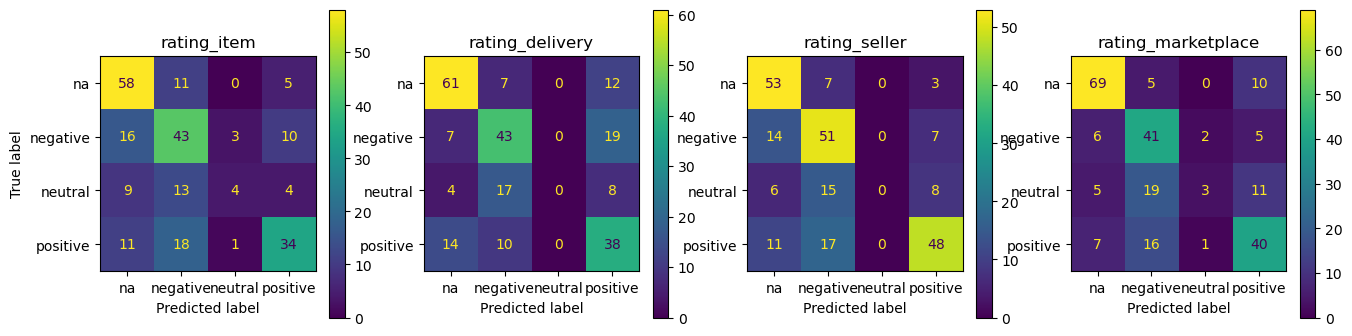

In [24]:
# show results

accuracy = {}

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))

cm = confusion_matrix(y_item_test, y_item_predicted, labels=model_item.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_item.classes_)
disp.plot(ax=axs[0])
axs[0].set_title('rating_item')
accuracy['rating_item'] = cm.diagonal().sum() / cm.sum()

cm = confusion_matrix(y_delivery_test['rating_delivery'], y_delivery_predicted, labels=model_delivery.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_delivery.classes_)
disp.plot(ax=axs[1])
axs[1].set_title('rating_delivery')
accuracy['rating_delivery'] = cm.diagonal().sum() / cm.sum()

cm = confusion_matrix(y_seller_test['rating_seller'], y_seller_predicted, labels=model_seller.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_seller.classes_)
disp.plot(ax=axs[2])
axs[2].set_title('rating_seller')
accuracy['rating_seller'] = cm.diagonal().sum() / cm.sum()

cm = confusion_matrix(y_marketplace_test['rating_marketplace'], y_marketplace_predicted, labels=model_marketplace.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_marketplace.classes_)
disp.plot(ax=axs[3])
axs[3].set_title('rating_marketplace')
accuracy['rating_marketplace'] = cm.diagonal().sum() / cm.sum()

print('Accuracy: ', accuracy)
print('Average accuracy: ', sum(accuracy.values()) / len(accuracy))

plt.show()

In [184]:
with open('model/svm_posneg_item.pkl', 'wb') as f:
    clf = pickle.dump(model_item, f)

with open('model/svm_posneg_delivery.pkl', 'wb') as f:
    clf = pickle.dump(model_delivery, f)

with open('model/svm_posneg_seller.pkl', 'wb') as f:
    clf = pickle.dump(model_seller, f)

with open('model/svm_posneg_marketplace.pkl', 'wb') as f:
    clf = pickle.dump(model_marketplace, f)